[View in Colaboratory](https://colab.research.google.com/github/danielcanueto/misc/blob/master/Detect_Retina_Damage_From_OCT_Images.ipynb)

In [8]:
!pip install kaggle
!pip install imblearn

In [0]:
!mkdir ~/.kaggle


In [6]:
!wget path_to_kaggle_json_with_api_token
!mv kaggle.json ~/.kaggle

--2018-07-26 09:40:46--  https://github.com/danielcanueto/datasets/blob/master/kaggle.json
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘kaggle.json.2’

kaggle.json.2           [ <=>                ]  41.84K  --.-KB/s    in 0.02s   

2018-07-26 09:40:46 (1.66 MB/s) - ‘kaggle.json.2’ saved [42847]



In [64]:
!kaggle datasets download -d gaborfodor/keras-pretrained-models

 98%|████████████████████████████████████████▏| 926M/943M [00:07<00:00, 139MB/s]
100%|█████████████████████████████████████████| 943M/943M [00:07<00:00, 137MB/s]


In [33]:
!kaggle datasets download -d paultimothymooney/kermany2018

100%|██████████████████████████████████████▉| 5.41G/5.42G [00:38<00:00, 163MB/s]
100%|███████████████████████████████████████| 5.42G/5.42G [00:38<00:00, 151MB/s]


In [38]:
!unzip /content/.kaggle/datasets/paultimothymooney/kermany2018/kermany2018.zip
!unzip /content/.kaggle/datasets/paultimothymooney/kermany2018/OCT2017.zip

Archive:  /content/.kaggle/datasets/paultimothymooney/kermany2018/kermany2018.zip
replace OCT2017.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  /content/.kaggle/datasets/paultimothymooney/kermany2018/OCT2017.zip
warning [/content/.kaggle/datasets/paultimothymooney/kermany2018/OCT2017.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
replace OCT2017 /.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [53]:
imageSize=224
train_dir = "OCT2017 /train/"
test_dir =  "OCT2017 /test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
#X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) # Re-comment to use full dataset: Step 2 of 2

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

100%|██████████| 243/243 [00:05<00:00, 46.12it/s]


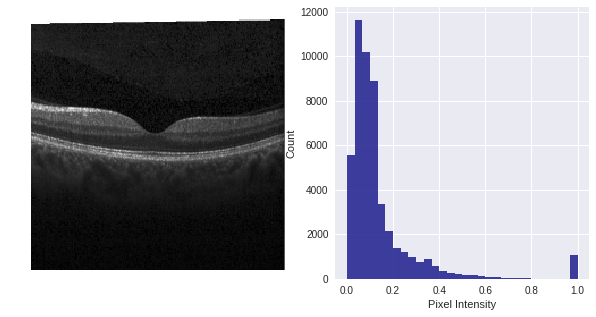

In [54]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])


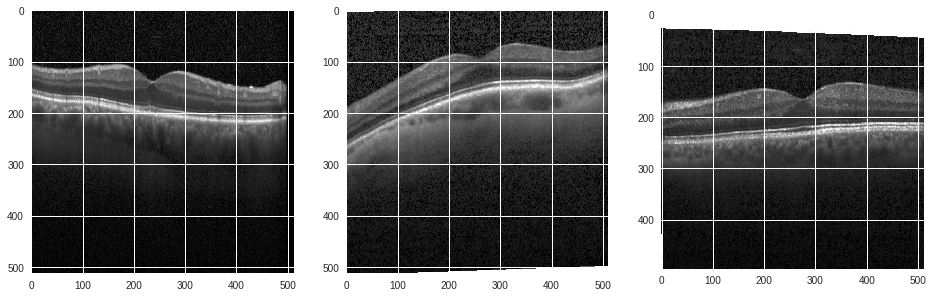

In [56]:
multipleImages = glob('OCT2017 /train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

Normal


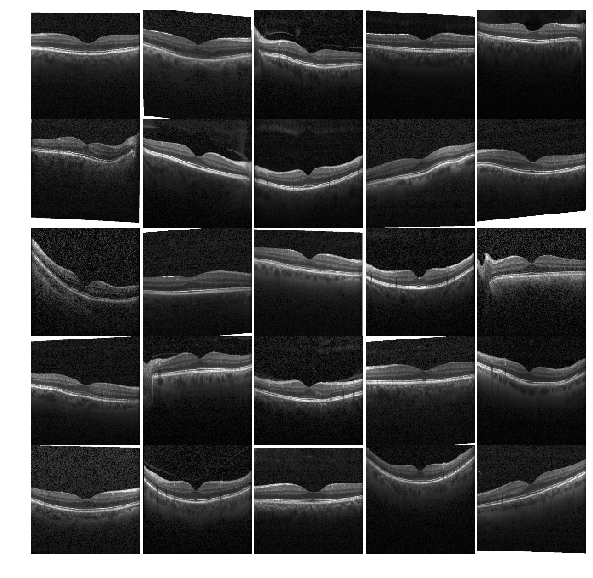

In [57]:
print("Normal")
multipleImages = glob('OCT2017 /train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

CNV


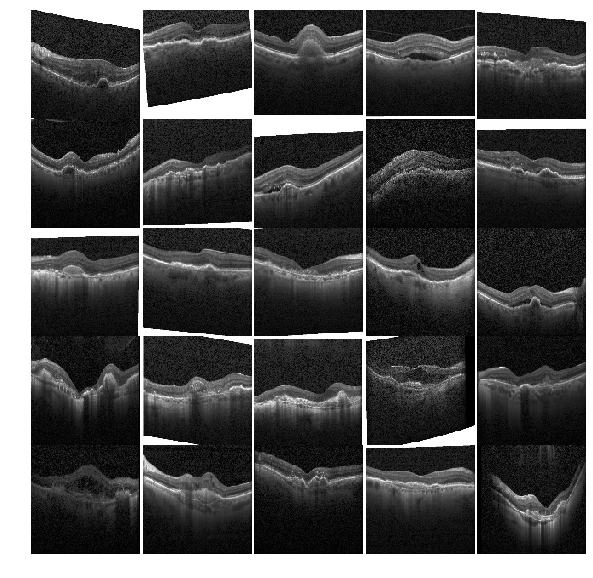

In [58]:
print("CNV")
multipleImages = glob('OCT2017 /train/CNV/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

DRUSEN


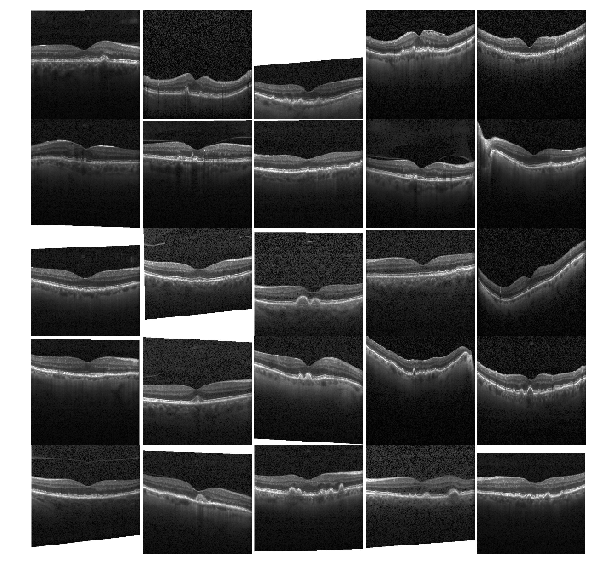

In [60]:
print("DRUSEN")
multipleImages = glob('OCT2017 /train/DRUSEN/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


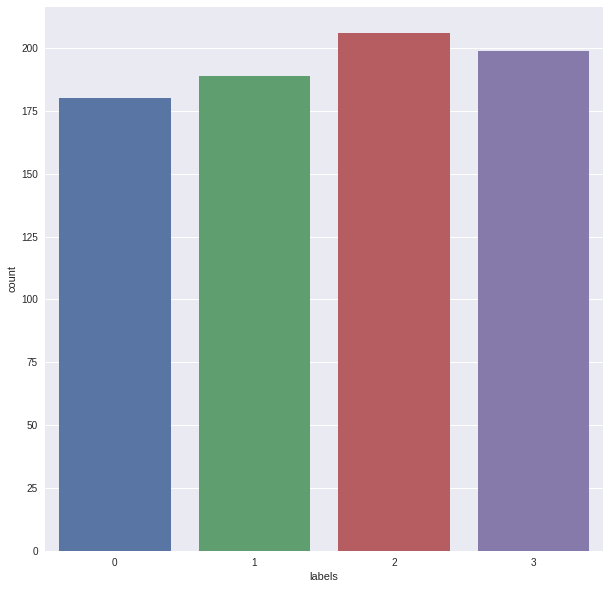

In [61]:
map_characters = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [0]:
map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weight_path1 = '/content/.kaggle/datasets/gaborfodor/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path2 = '/content/.kaggle/datasets/gaborfodor/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3))
pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.RMSprop(lr=0.0001/2.0)
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels, batch_size = 32):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Conv2D(256, kernel_size = (3,3), padding = 'valid')(x)
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        class_weight=classweight, 
                        validation_data=(xtest,ytest), 
                        verbose=1,
                        callbacks = callbacks_list+[MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,4,83,optimizer1,map_characters1)

In [0]:
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_2,weight_path2,class_weight1,4,8,optimizer1,map_characters1)

{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


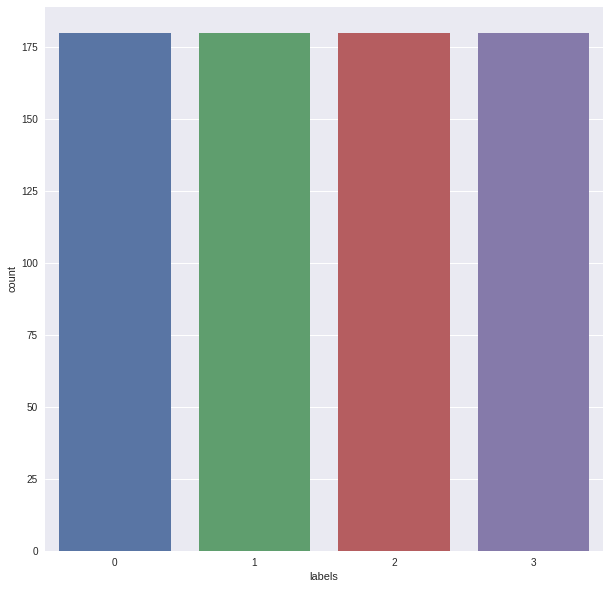

In [67]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 4)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 4)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = imageSize,imageSize,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = imageSize,imageSize,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [68]:
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight1)
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.075      1.02380952 0.93932039 0.97236181]
New Class Weights:  [1. 1. 1. 1.]


In [0]:
# Shuffle data to permit further subsampling
from sklearn.utils import shuffle
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

720/720 [==============================] - 10s 13ms/step - loss: 0.5668 - acc: 0.7792 - val_loss: 0.2265 - val_acc: 0.9236
Epoch 5/50
720/720 [==============================] - 10s 13ms/step - loss: 0.4018 - acc: 0.8528 - val_loss: 0.2124 - val_acc: 0.9236
Epoch 6/50
720/720 [==============================] - 10s 13ms/step - loss: 0.3042 - acc: 0.8750 - val_loss: 0.1960 - val_acc: 0.9306
Epoch 7/50
720/720 [==============================] - 10s 13ms/step - loss: 0.2387 - acc: 0.9153 - val_loss: 0.1758 - val_acc: 0.9375
Epoch 8/50
720/720 [==============================] - 10s 13ms/step - loss: 0.1939 - acc: 0.9222 - val_loss: 0.1621 - val_acc: 0.9514
Epoch 9/50
720/720 [==============================] - 10s 13ms/step - loss: 0.1701 - acc: 0.9306 - val_loss: 0.1577 - val_acc: 0.9444
Epoch 10/50
720/720 [==============================] - 10s 13ms/step - loss: 0.1419 - acc: 0.9486 - val_loss: 0.1406 - val_acc: 0.9583
Epoch 11/50
720/720 [==============================] - 10s 13ms/step - l

720/720 [==============================] - 10s 13ms/step - loss: 0.0485 - acc: 0.9903 - val_loss: 0.1026 - val_acc: 0.9653
Epoch 19/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0398 - acc: 0.9903 - val_loss: 0.0997 - val_acc: 0.9653
Epoch 20/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0396 - acc: 0.9861 - val_loss: 0.1092 - val_acc: 0.9653
Epoch 21/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0374 - acc: 0.9903 - val_loss: 0.1048 - val_acc: 0.9653
Epoch 22/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0378 - acc: 0.9958 - val_loss: 0.1091 - val_acc: 0.9514
Epoch 23/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0316 - acc: 0.9944 - val_loss: 0.0935 - val_acc: 0.9653
Epoch 24/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0267 - acc: 0.9958 - val_loss: 0.0977 - val_acc: 0.9653
Epoch 25/50
720/720 [==============================] - 10s 13ms/ste

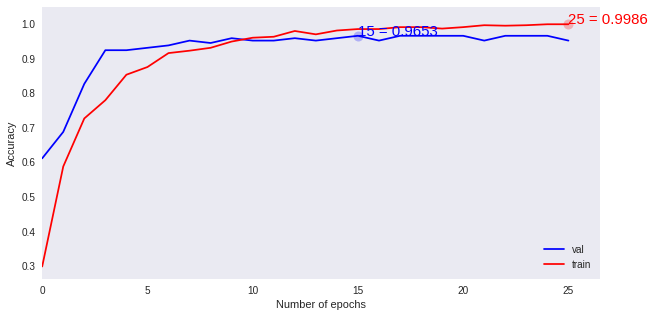

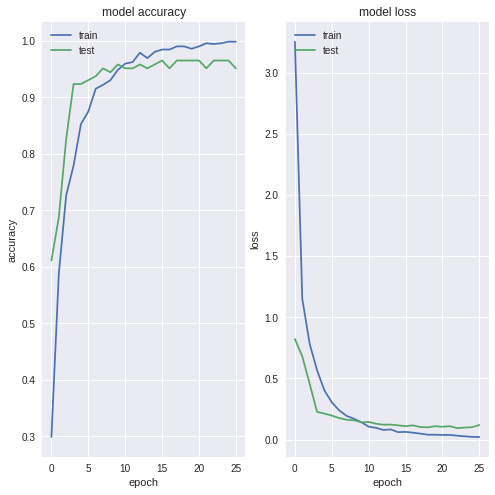

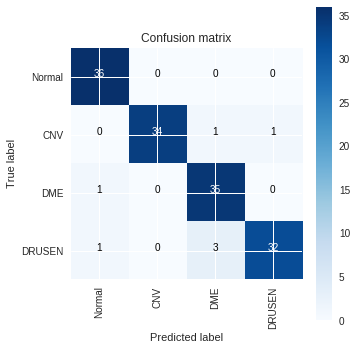

In [71]:
pretrainedNetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:2000], Y_testRosHot[:2000],
                  pretrained_model_1,
                  weight_path1,
                  class_weight2,
                  4,
                  50,
                  optimizer1,
                  map_characters1,
                 batch_size = 128)

In [72]:
X_trainRosReshaped.size

108380160

In [0]:
#pretrainedNetwork(X_trainRosReshaped[:10000], 
   #               Y_trainRosHot[:10000], 
   #               X_testRosReshaped[:2000], 
   #               Y_testRosHot[:2000],
   #               pretrained_model_2,
  #                weight_path2,
  #                class_weight2,
   #               4,
  #                50,
  #                optimizer1,
  #                map_characters1,
  #               batch_size = 64)

In [0]:
#To Do: (1) Try to get accuracy up from 95% to 99%; (2) Add data augmentation; (3) Add ROC curve

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

720/720 [==============================] - 10s 13ms/step - loss: 1.0665 - acc: 0.7694 - val_loss: 0.8518 - val_acc: 0.8056
Epoch 5/50
720/720 [==============================] - 10s 13ms/step - loss: 0.8333 - acc: 0.8306 - val_loss: 0.4347 - val_acc: 0.8889
Epoch 6/50
720/720 [==============================] - 10s 13ms/step - loss: 0.6148 - acc: 0.8431 - val_loss: 0.4129 - val_acc: 0.9097
Epoch 7/50
720/720 [==============================] - 10s 13ms/step - loss: 0.4723 - acc: 0.8986 - val_loss: 0.2605 - val_acc: 0.9028
Epoch 8/50
720/720 [==============================] - 10s 13ms/step - loss: 0.2900 - acc: 0.9097 - val_loss: 0.4310 - val_acc: 0.8750
Epoch 9/50
720/720 [==============================] - 10s 13ms/step - loss: 0.2768 - acc: 0.9194 - val_loss: 0.1705 - val_acc: 0.9444
Epoch 10/50
720/720 [==============================] - 10s 13ms/step - loss: 0.1912 - acc: 0.9417 - val_loss: 0.2439 - val_acc: 0.9028
Epoch 11/50
720/720 [==============================] - 10s 13ms/step - l

720/720 [==============================] - 10s 13ms/step - loss: 0.0688 - acc: 0.9792 - val_loss: 0.1687 - val_acc: 0.9444
Epoch 19/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0472 - acc: 0.9833 - val_loss: 0.1406 - val_acc: 0.9444
Epoch 20/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0272 - acc: 0.9903 - val_loss: 0.1239 - val_acc: 0.9514
Epoch 21/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0215 - acc: 0.9917 - val_loss: 0.1384 - val_acc: 0.9375
Epoch 22/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0270 - acc: 0.9903 - val_loss: 0.1356 - val_acc: 0.9375
Epoch 23/50
720/720 [==============================] - 10s 13ms/step - loss: 0.0388 - acc: 0.9861 - val_loss: 0.1375 - val_acc: 0.9375
Epoch 00023: early stopping

Keras CNN - accuracy: 0.9375 


             precision    recall  f1-score   support

     Normal       0.95      0.97      0.96        36
        CNV       0.92      0.97  

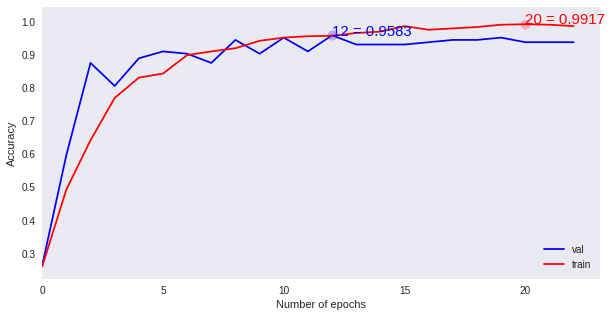

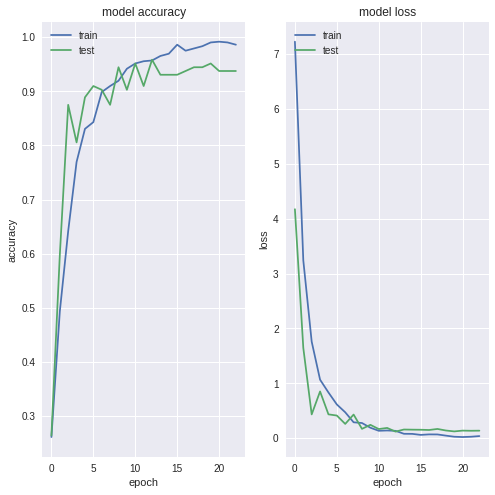

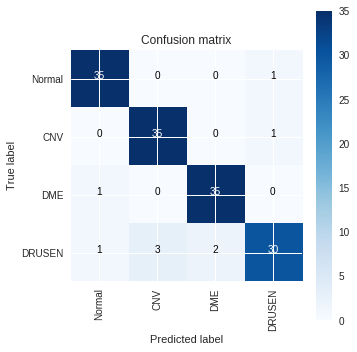

In [73]:
pretrainedNetwork(X_trainRosReshaped[:20000], Y_trainRosHot[:20000], X_testRosReshaped[:10000], Y_testRosHot[:10000],
                  pretrained_model_1,
                  weight_path1,
                  class_weight2,
                  4,
                  50,
                  optimizer1,
                  map_characters1,
                 batch_size = 128)